In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import helpers.cusplot as cplt
import scipy.optimize as sco
import scipy.constants as scc
from ionoptics import geometry as geo
from ionoptics import beamline as bl

from functools import partial


## constants (SI)

In [ ]:
# general
c = 299792458
m_pr = 938.272 # MeV

# kicker
brho = 1.23 
lgap = 0.1
kick_l = 0.5
N = 20
u0 = 4*np.pi*1e-7

l = 3 # dist. kicker-septum

# charge distribution
sigma = 0.015
delta_x_max = 0.01

# septum
w = 0.005 # 5 mm thickness for DC septum (CERN paper)
# assuming infinte extend in y (valid - 100 mm beam tube > 6 sigma)

In [ ]:
# numeric integration of current fraction 
# incident on septum
d = {}

for delta_x in np.linspace(0,delta_x_max,10):
    I = 0
    for step in np.linspace(2*sigma-w/2, 2*sigma + w/2,10):
        I += np.exp(-(step-delta_x)**2/(2*sigma**2))*w/10
    
    I_norm = 1/(np.sqrt(2*np.pi)*sigma)*I
    
    d[delta_x] = I_norm

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(*zip(*sorted(d.items())))
ax.set_xlabel('delta x [m]')
ax.set_ylabel('fraction')

ax.set_title('int. fraction on {} mm septum'.format(w*1e3))

#convert spat. to curr_off
def dx_to_dI(dx):
    dThet = dx/l
    dI = brho*lgap/(u0*kick_l*N)*dThet
    return round(dI,3)

cplt.add_axis(ax, 'x', dx_to_dI, 'delta I [A]' )

plt.show()

## el. vs. magn. field

In [ ]:
# integrated B-field / E-field norm. to kick angle
M = 1 # 1:MeV, 1e-3: keV, ...

T = np.arange(0,100,10)* M# MeV
p = np.sqrt(T**2+2*T*m_pr) # MeV

mag = p*1e-3/0.3 * M

el = p/m_pr*c*p*1e-3/0.3 * M

ax = plt.gca()
ax.set_xlabel(r'$E$ [MeV]')
ax.set_xticks(T)
ax.set_ylabel(r'$BL/\Theta$ [Tm/rad]')
ax.set_title('electric vs. magnetic field')
ax1 = ax.twinx()
ax1.set_ylabel(r'$EL/\Theta$ [V/rad]')
ax1.spines['right'].set_color('r')

ax.plot(T,mag)
ax1.plot(T,el, c = 'r')
ax.legend(['int., norm. B-field'], loc = 2)
ax1.legend(['int., norm. E-field'], loc = 4)

plt.savefig('/home/marius/Jülich/Multiplexer/Plots/elvsmagn')
plt.show()

## beam tube induction - paper

In [ ]:
def B(t,f,tau,B0):
    w = 2*np.pi*f
    
    t0 = np.pi/w
    
    C1 = w*tau
    
    tleq = np.asarray([time for time in t if time <= t0])
    tgeq = np.asarray([time for time in t if time >= t0])
    
    Bleq = B0*(1/np.sqrt(1+C1**2)*np.sin(w*tleq-np.arctan(w*tau))+C1/(1+C1**2)*np.exp(-tleq/tau))
    Bgeq = B0*C1/(1+C1**2)*(1+np.exp(t0/tau))*np.exp(-tgeq/tau)
    
    return np.append(Bleq,Bgeq)

In [ ]:
sigma = 1.33e6 # S/m
a = 65e-3/2 # inner radius
d = 5e-3 # beam tube thickness

tau = scc.mu_0*sigma*a*d/2

fig,ax = plt.subplots(5,1,figsize = (5,20))

for i,f in enumerate([1e2,5e2,1e3,5e3,10e3]):

    w = 2*np.pi*f
    
    t0 = np.pi/w

    t = np.linspace(0,5*t0,1000)
    tleq = np.asarray([time for time in t if time <= t0])
    
    ax[i].plot(t,B(t,f,tau,50e-3))
    ax[i].plot(tleq,50e-3*np.sin(w*tleq))
    ax[i].text(0,0,'{:.2e}'.format(B(t,f,tau,50e-3).max()))
    ax[i].set_title('{:.1e}'.format(f))
    

PATH_TO_DATA = '../../Misc/'
FILENAME = 'beam_induction_sine_circular tube_{:.2e}_{:.2e}_{:.2e}'.format(sigma,a,d)
plt.savefig(PATH_TO_DATA + FILENAME, format = 'png', dpi=900)

In [ ]:
# from paper
t = np.linspace(0,7e-6,100)
plt.plot(t,B(t,0.125e6,1e-6,1))

## testing point-to-parallel w/ 7 quadrupoles

In [2]:
# distances

# point - to - parallel: M11 = 0, M33 = 0

# l1 - L_Fe - l1 - L_Fe - l1,l3,l1 - L_Fe - l2 - L_Fe - l2 - L_Fe - l1,l3,l1 - L_Fe - l1 - L_Fe - l1

L_Fe = 0.3
l1 = 0.3
l2 = 0.5
l3 = 0.97

# l1,l3,l1
l4 = 2*l1+l3

l5 = l1+l3

#TODO: need bl functions

In [7]:
# 7 quads Benat
k0,k1,k2,k3 = 0.286,1.697,2.442,5.275

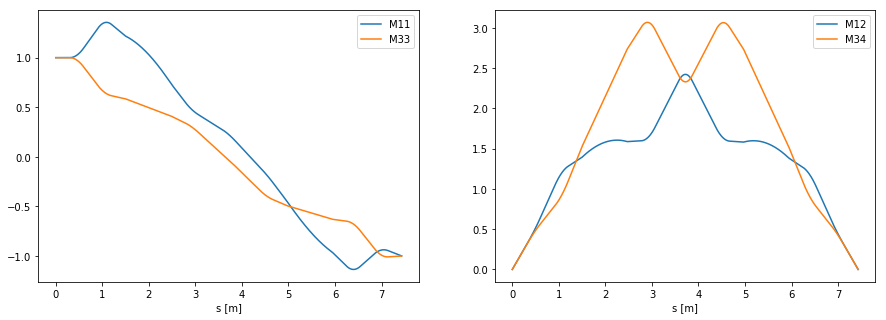

In [4]:
lengths = [l1,L_Fe,l1,L_Fe,l1,l3,l1,L_Fe,l2,L_Fe,l2,L_Fe,l1,l3,l1,L_Fe,l1,L_Fe,l1]
elements = [bl.drift,bl.qdf,bl.drift,bl.qf,bl.drift,
            partial(bl.dipole, L_max = 0.97, alpha = 0.67, beta=0.18),
            bl.drift,bl.qdf,bl.drift,bl.qf,bl.drift,bl.qdf,bl.drift,
            partial(bl.dipole, L_max = 0.97, alpha = 0.67, beta=0.18),
            bl.drift,bl.qf,bl.drift,bl.qdf,bl.drift]

elements = bl.eles_to_peles(elements,bl.opt_quad_mult(elements,lengths),S=True)
bl.plot_M_vs_s(elements,lengths, figsize = (15,5))



plt.show()

## Multiplexer geometry BK

In [ ]:
x_sept = 4*7e-3
x_at_max_prop = 0.1
x_add = x_at_max_prop - x_sept
l_kick = 0.5
l_sept = 0.5
sept_type = 'DC'
start_kick = 0.001 # smallest kick-angle
step_kick = 0.001 # step size kick-angle

list_perm = np.linspace(0,1,1001) # range of septum anglesenvelope
max_prop = 2

ax,data = geo.plot_comb_kick_sept(x_sept, x_add, 0,0, l_kick, l_sept, sept_type, 
                        start_kick, step_kick, list_perm, max_prop, figsize = (15,5),brho=0.98)

plt.show()

In [ ]:
kick_d = data[0][0.3]

dks = [d[1] for d in data[1] if d[0] == kick_d]
dks_av = sum(dks)/len(dks)
# kicker-septum


dsf = [d[1] for d in data[2] if d[0] == kick_d]
dsf_av = sum(dsf)/len(dsf)
# septum - final

(kick_d,dks_av,dsf_av)

In [ ]:
0.032*0.98/0.5